<a href="https://colab.research.google.com/github/sonnyloweus/QuantumDynamicsAI/blob/main/Quantum_Transformer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Brickworks Circuit Generator



This Python script facilitates the generation and simulation of quantum circuits using Qiskit, focusing on constructing and running quantum circuits with unitary gates, and it employs PyTorch to handle quantum simulation data in batches for subsequent machine learning tasks. Here's a detailed breakdown of what each part of the code does:

**1. Imports and Dependencies**
*   numpy: Used for numerical operations and random number generation.
*   qiskit: Quantum computing library used to create and simulate quantum circuits.
*   torch: PyTorch, used for handling tensor operations and neural network functionalities.
*   pickle: For saving and loading serialized Python objects.
*   matplotlib: For plotting data, though not directly used in the code.

**2. Helper Functions**
*   choose_two_random_qubits(n): Randomly selects two qubits from a quantum register of size n, ensuring they are consecutive.
*   random_conservation_unitary(): Generates a 4x4 unitary matrix with specific constraints where the middle 2x2 block is a random unitary matrix, and the diagonal elements are complex exponentials. This matrix represents a unitary operation acting on two qubits.
*   save_circuit_params(params, file_name): Saves the provided parameters to a file using pickle.
*   generate_circuit_params(circuit_length, num_qbits, file_name): Generates circuit parameters including random unitary operators and the qubits they act on if no filename is provided.
If a filename is provided, it loads the parameters from the file.
*   generate_circuit_from_params(params): Constructs a quantum circuit based on the provided parameters. Initializes a quantum register with Hadamard gates to create a superposition, measures it to record the initial state, then applies the unitary operators.
Measures the quantum register again to obtain the final state.
*   get_simulator_circuit(circuit): Compiles the quantum circuit for simulation using Qiskit Aer's statevector simulator.
*   run_batch(circuit, compiled_circuit, simulator, batch_size): Runs the quantum circuit on a simulator, executing it batch_size times. Returns the initial and final states recorded from the simulation.

**3. Dataset Classes**
*   QuantumSimulationDataset(Dataset):
A PyTorch dataset that handles quantum simulation data.
Generates quantum circuits and simulates them to provide batches of initial and final states.

**4. Additional Functions for Dense Unitary Circuits**
*   generate_dense_unitary_circuit_from_params(params): Constructs a quantum circuit and converts it to a dense unitary matrix suitable for fast matrix operations.
*   get_final_state_vector(batched_initial_state, op_mat): Computes the final state vector from a batch of initial states by applying the unitary matrix.
*   sample_from_state_vector(probs, num_qbits, num_samples): Samples bitstrings from the probability distribution represented by the final state vector.
*   bitstring_from_initial_state(initial_state, num_qbits): Converts the initial state to its corresponding bitstring representation.
*   decimal_from_initial_state(initial_state, num_qbits): Converts the bitstring to its decimal equivalent.
*   run_batch_dense_torch(unitary_circuit, num_qbits, batch_size, num_samples, device, inverse_density): Runs the quantum simulation using dense unitary matrix operations on a GPU. It initializes states with certain density, applies the unitary circuit, and samples from the resulting state vector.

**5. Advanced Dataset Class for Fast Simulation**
*   QuantumSimulationDatasetFast(Dataset):
A more advanced PyTorch dataset designed for faster simulation using dense unitary matrices.
Utilizes GPU for efficient state vector calculations and sampling.

**6. Main Execution**
Generates parameters for a quantum circuit and saves them.
Loads these parameters to create a dataset.
Iterates over the dataset, printing initial and final states for each batch.

**Summary:**

This code provides a comprehensive framework for generating, simulating, and analyzing quantum circuits using Qiskit and PyTorch. It supports the creation of random unitary gates, simulates quantum circuits in batch mode, and integrates with PyTorch for efficient data handling and potential machine learning applications. The use of dense unitary matrices and GPU acceleration enhances the performance for simulations involving large quantum systems.

In [ ]:
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 16.9 MB/s eta 0:00:00


In [ ]:
!pip install qiskit

In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=bd33bb152352417734804c24a2f6fc2cc8cbd8543a06326347acb67d37bf50f0
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
directory_path = '/content/drive/MyDrive/Quantum/'

Mounted at /content/drive


In [ ]:
import numpy as np
import pylatexenc
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.quantum_info import random_unitary
from qiskit.quantum_info import Operator
from qiskit.visualization import circuit_drawer
import torch.nn.functional as F
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

# returns two random numbers within a range defined by n in a circular mannar
def choose_two_random_qubits(n):
  a = np.random.randint(0, n)
  b = (a+1) % n
  return a,b

def random_conservation_unitary():
    # Initialize a 4x4 complex matrix
    unitary_matrix = np.zeros((4, 4), dtype=complex)
    # Generate a random 2x2 unitary matrix
    inside = random_unitary(2)
    # Insert the 2x2 unitary matrix in the center of the 4x4 matrix
    unitary_matrix[1:3, 1:3] = inside
    # Set random phases on the diagonal elements
    unitary_matrix[0, 0] = np.exp(-1j * np.random.rand() * 2 * np.pi)
    unitary_matrix[3, 3] = np.exp(-1j * np.random.rand() * 2 * np.pi)
    return Operator(unitary_matrix)

def save_circuit_params(params, file_name):
  with open(directory_path + file_name, 'wb') as file:
    pickle.dump(params, file)

def generate_circuit_params(circuit_length = None, num_qbits = None, file_name = None):
  #length is a number, operators is a list of qiskit Operator, qbits are list of tuples
  if file_name is not None:
    with open(file_name, 'rb') as f:
      params = pickle.load(f)
  else:
    params = {'len': circuit_length, 'num_qbits': num_qbits, 'operators': [], 'qbits': []}
    for i in range(circuit_length):
      params['operators'].append(random_conservation_unitary())
      params['qbits'].append(choose_two_random_qubits(num_qbits))
  return params

def generate_circuit_from_params(params):
    n = params['num_qbits']
    num_gates = params['len']

    # Create a Quantum Circuit acting on the q register
    circuit = QuantumCircuit(n, 2 * n)

    # Create uniform superposition
    circuit.h(range(n))
    circuit.barrier()

    # this makes the gpu implementation really slow, but i can’t think of any other way to run qiskit with batched initial state
    # possible solution:
    # initial_state = params.get('initial_state', None)
    # if initial_state:
    #    circuit.append(initial_state, range(n))

    # Measure the initial superposition state
    circuit.measure(range(n), range(n, 2 * n))
    circuit.barrier()

    # Apply gates from params['operators'] to specified qubits
    for i in range(num_gates):
        operator = params['operators'][i]
        qubits = params['qbits'][i]
        circuit.append(operator, qubits)

    # Final measurement to map quantum state to classical bits
    circuit.measure(range(n), range(n))

    # Draw the circuit for visualization (optional)
    #circuit.draw(output='mpl')
    circuit.draw(output='text', filename='temp.txt', scale=0.5)
    img = circuit_drawer(circuit, output='mpl')
    img.savefig('circuit_diagram.png')
    return circuit

def get_simulator_circuit(circuit):
  simulator = Aer.get_backend('aer_simulator_statevector')
  #simulator.set options(device=’GPU’)
  compiled_circuit = transpile(circuit, simulator)
  return compiled_circuit, simulator

def run_batch(circuit, compiled_circuit, simulator, batch_size):
  job = simulator.run(compiled_circuit, shots=batch_size, memory=True)
  #job = execute(circuit, simulator, shots = batch size)
  result = job.result().get_memory(circuit)
  results = np.array([list(sample) for sample in result], dtype=float)
  n = results.shape[1]//2
  initial_state = results[:, :n]
  final_state = results[:, n:]
  return initial_state, final_state

class QuantumSimulationDataset(Dataset):
  def __init__(self, parameters, batch_size, num_batches):
    self.batch = batch_size
    self.num_batches = num_batches
    self.circuit = generate_circuit_from_params(parameters)
    self.compiled_circuit, self.simulator = get_simulator_circuit(self.circuit)

  def __len__(self):
    return self.num_batches

  def __getitem__(self, _):
    initial_states, final_states = run_batch(self.circuit, self.compiled_circuit, self.simulator, self.batch)
    return torch.Tensor(initial_states), torch.Tensor(final_states)

# this allows for fast matrix−matrix products for small systems
def generate_dense_unitary_circuit_from_params(params):
  n = params['num_qbits']
  num_gates = params['len']
  circuit = QuantumCircuit(n, 0)
  for i in range(num_gates):
    operator = params['operators'][i]
    qubits = params['qbits'][i]
    circuit.append(operator, qubits)
  circuit.draw(output='text', filename='temp.txt', scale=0.5)
  op = Operator(circuit)
  return torch.tensor(op.to_matrix(), dtype=torch.cfloat)

def get_final_state_vector(batched_initial_state, op_mat):
  sampled_final_state = torch.matmul(op_mat.unsqueeze(0),batched_initial_state.unsqueeze(2))
  probs = sampled_final_state * sampled_final_state.conj()
  return torch.real(probs)

def sample_from_state_vector(probs, num_qbits, num_samples):
  decimal = torch.multinomial(probs.squeeze(-1), num_samples, replacement=True)
  mask = 2 ** torch.arange(num_qbits).to(decimal.device, decimal.dtype)
  return decimal.unsqueeze(-1).bitwise_and(mask).ne(0).float()

def bitstring_from_initial_state(initial_state, num_qbits):
  decimal = torch.argmax(initial_state, dim = -2)
  mask = 2 ** torch.arange(num_qbits).to(decimal.device, decimal.dtype)
  return decimal.unsqueeze(-1).bitwise and(mask).ne(0).float().squeeze(1)

def decimal_from_initial_state(initial_state, num_qbits):
  mask = 2 ** torch.arange(num_qbits).to(initial_state.device, torch.int64)
  return torch.sum( (mask * initial_state) , -1)

@torch.no_grad()
def run_batch_dense_torch(unitary_circuit, num_qbits, batch_size, num_samples, device, inverse_density = 3):
  bits = torch.zeros((batch_size, num_qbits), dtype=torch.bool, device=device)
  x = np.arange(num_qbits)
  rng = np.random.default_rng()
  perms = rng.permuted(np.tile(x, batch_size).reshape(batch_size, x.size), axis=1)[:, :num_qbits//inverse_density]
  bits[np.arange(batch_size).reshape(batch_size, 1), perms] = True
  decimal = decimal_from_initial_state(bits, num_qbits)
  one_hot = F.one_hot(decimal, num_classes=2**num_qbits)
  final_state = get_final_state_vector(one_hot.cfloat(), unitary_circuit)
  sample = sample_from_state_vector(final_state, num_qbits, num_samples)
  return bits.float(), sample

class QuantumSimulationDatasetFast(Dataset):
  def __init__(self, parameters, batch_size, num_batches, num_final_states_per_initial_state, device, inverse_density):
    self.device = device
    self.batch_size = batch_size // num_final_states_per_initial_state
    self.num_batches = num_batches
    self.num_samples = num_final_states_per_initial_state
    self.num_qubits = parameters['num_qbits']
    self.mat = generate_dense_unitary_circuit_from_params(parameters).to(device)#.to sparse()
    self.inverse_density = inverse_density

  def __len__(self):
    return self.num_batches

  def __getitem__(self, _):
    initial_states, final_states = run_batch_dense_torch(self.mat, self.num_qubits, self.batch_size, self.num_samples, self.device, self.inverse_density)
    initial_states = initial_states.unsqueeze(1).expand_as(final_states).clone()
    return initial_states.flatten(end_dim=-2), final_states.flatten(end_dim=-2)

if __name__ == '__main__':
  params = generate_circuit_params(12, 12)
  params['qbits'] = [(0,1),(2,3),(4,5),(6,7), (8,9), (10,11), (1,2),(3,4),(5,6),(7,8),(9,10), (11,0)]
  # (0,1),(2,3),(4,5),(6,7), (8,9), (10,11), (1,2),(3,4),(5,6),(7,8),(9,10), (11,0)]"
  # (0,1),(2,3),(4,5),(6,7), (8,9), (10,11), (1,2),(3,4),(5,6),(7,8),(9,10), (11,0),
  # (0,1),(2,3),(4,5),(6,7), (8,9), (10,11), (1,2),(3,4),(5,6),(7,8),(9,10), (11,0)]

  save_circuit_params(params, 'dense_small.param')

  params = generate_circuit_params(file_name = directory_path + 'dense_small.param')

  # If GPU available, use below line
  #dataset = QuantumSimulationDatasetFast(params, 64,4, device = 'cuda', inverse_density=3)
  batches = 1000
  dataset = QuantumSimulationDataset(params, 64, batches)


  #for i, (initial, final) in enumerate(dataset):
    #print(i, initial[0], final[0])




NameError: name '_C' is not defined

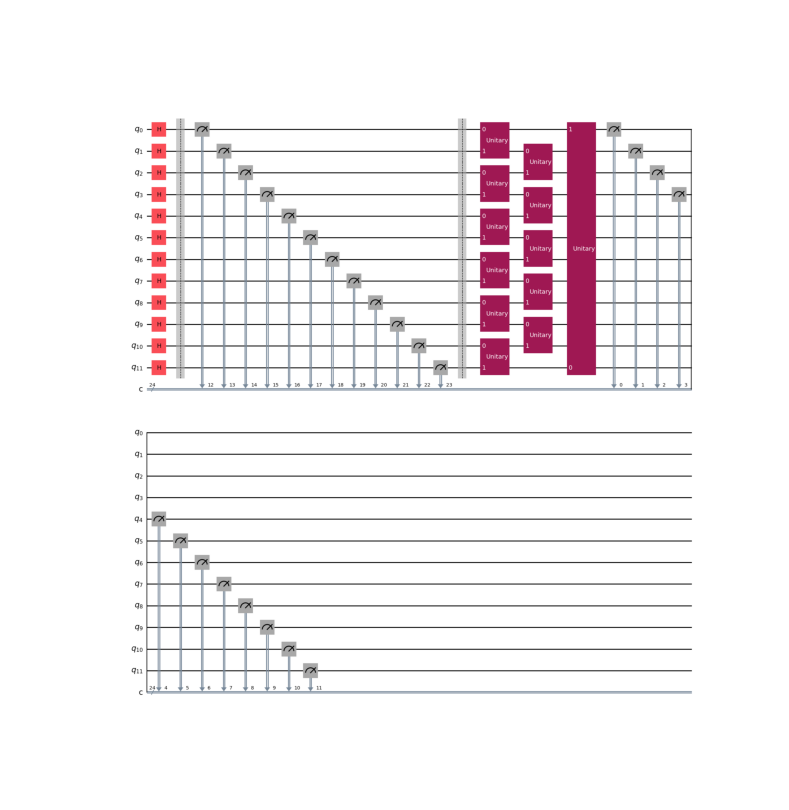

In [ ]:
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

figure(figsize=(5, 5), dpi=200)
img = mpimg.imread('circuit_diagram.png')

plt.imshow(img)
plt.axis('off')
plt.show()

# Data Collection

In [ ]:
print(len(dataset))
# for QuantumSimulationDatasetFast:
# for i, (initial, final) in enumerate(dataset):
#   print(initial[0], final[0:4])
#   if (i == 64):
#     break

# for QuantumSimulationDataset:
# for i, (initial, final) in enumerate(dataset):
#   print(initial, final)
#   if (i == 1):
#     break

import pandas as pd

data = []

for index, (initial_states, final_states) in enumerate(dataset):
    if(index == len(dataset)):
      break
    initial_states_list = initial_states.numpy().tolist()
    final_states_list = final_states.numpy().tolist()

    for initial, final in zip(initial_states_list, final_states_list):
        data.append({'Initial_State': initial, 'Final_State': final})

df = pd.DataFrame(data)

filename = 'quantum_simulation_data.pkl'
file_path = os.path.join(directory_path, filename)
# df.to_csv('quantum_simulation_data.csv', index=False)

df.to_pickle(file_path)
print(df)
df.head()

1000
                                           Initial_State  \
0      [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1      [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...   
3      [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...   
4      [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...   
...                                                  ...   
63995  [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...   
63996  [0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
63997  [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...   
63998  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...   
63999  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...   

                                             Final_State  
0      [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
1      [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2      [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...  
3      [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 

,Initial_State,Final_State
0,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ..."
3,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
4,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."


# Transformer

# Data Preprocessing

In [3]:
import ast
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Load and prepare the data
data_path = '/content/drive/MyDrive/Quantum/quantum_simulation_data.pkl'
data = pd.read_pickle(data_path)

def to_tensor(item):
    if isinstance(item, torch.Tensor):
        # If already a tensor, clone and detach it to prevent issues
        return item.clone().detach()
    elif isinstance(item, str):
        # Convert string to list using ast.literal_eval
        item_list = ast.literal_eval(item)
        return torch.tensor(item_list)
    elif isinstance(item, list):
        return torch.tensor(item)
    else:
        raise ValueError(f"Expected a list or tensor, but got {type(item)}")

data.shape

(64000, 2)

In [20]:
data.head()

,Initial_State,Final_State
0,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ..."
3,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
4,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."


In [4]:
from torch.utils.data import TensorDataset, DataLoader, random_split

data['Initial_State'] = [to_tensor(lst) for lst in data['Initial_State']]
data['Final_State'] = [to_tensor(lst) for lst in data['Final_State']]

print(data['Final_State'][0])

# Convert Series to list of tensors before stacking
initial_state_tensors = list(data['Initial_State'])
final_state_tensors = list(data['Final_State'])

dataset = TensorDataset(torch.stack(initial_state_tensors), torch.stack(final_state_tensors))
print(dataset)

# Define the split sizes (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Perform the train-test split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Example of how to use DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# X_train, X_test, y_train, y_test = train_test_split(initial_state_tensors, final_state_tensors, test_size=0.2, random_state=42)
# train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=False)
# test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=32, shuffle=False)

tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.])


# Model Definition

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, heads):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.heads = heads
        # distribution of dimensionaltiy
        self.head_dim = d_model // heads

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, d_model) # concat all heads back into one

        # binary output
        self.sigmoid = nn.Sigmoid()

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        # computing attention scores
        energy = torch.einsum("nqhd,nkhd->nhqk", [query, keys])
        # masking
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-inf"))
        # attention weights
        attention = torch.softmax(energy / (self.d_model ** (1/2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        out = self.sigmoid(out) # output is within range 0, 1

        out_binary = (out >= 0.5).float()

        return out_binary

class TransformerBlock(nn.Module):
    def __init__(self, d_model, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        # attention block, normalization, feedforward, normalization again (mimicing GPT)
        self.attention = SelfAttention(d_model, heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, forward_expansion * d_model),
            nn.ReLU(),
            nn.Linear(forward_expansion * d_model, d_model),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # skip connection
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

# Encoder
class Encoder(nn.Module):
    def __init__(self, device, input_dim, d_model, heads, dropout, num_layers, forward_expansion):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.device = device
        self.num_tokens = 2 # binary

        self.embedding = nn.Embedding(self.num_tokens, d_model)
        self.position_embedding = nn.Embedding(input_dim, d_model)

        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, heads, dropout, forward_expansion)
            for _ in range(num_layers)]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        out = self.dropout(self.embedding(x) + self.position_embedding(positions))

        for layer in self.layers:
            out = layer(out, out, out, mask) # encoder has same keys, queries, and values

        #print('Encoder Out:', out.shape)

        return out

class DecoderBlock(nn.Module):
    def __init__(self, device, d_model, heads, dropout, forward_expansion):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(d_model, heads)
        self.norm = nn.LayerNorm(d_model)
        self.transformer_block = TransformerBlock(d_model, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, tgt_mask):
        attention = self.attention(x, x, x, tgt_mask)
        query = self.dropout(self.norm(attention + x)) # skip connection
        out = self.transformer_block(value, key, query, src_mask)
        return out

class Decoder(nn.Module):
    def __init__(self, device, output_dim, d_model, heads, dropout, num_layers, forward_expansion):
        super(Decoder, self).__init__()
        self.num_tokens = 2 # binary
        self.device = device
        self.word_embedding = nn.Embedding(self.num_tokens, d_model)
        self.position_embedding = nn.Embedding(output_dim, d_model)

        self.layers = nn.ModuleList(
            [DecoderBlock(device, d_model, heads, dropout, forward_expansion)
             for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(d_model, output_dim)
        self.dropout = nn.Dropout(dropout)
        # binary output
        self.sigmoid = nn.Sigmoid()

    # x is input into decoder
    def forward(self, x, enc_out, src_mask, tgt_mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, tgt_mask)

        out = self.fc_out(x)
        out = self.sigmoid(out)  # Output is now within range 0, 1
        out_binary = (out >= 0.5).float()  # Convert to binary if needed

        mode_tensor, _ = out_binary.mode(dim=1)
        # Flatten the mode_tensor to get a single tensor of 12 elements
        flattened_mode_tensor = mode_tensor.view(out_binary.size(0), out_binary.size(2))

        return flattened_mode_tensor

class QuantumTransformer2(nn.Module):
    def __init__(
        self,
        src_pad_idx,
        tgt_pad_idx,
        d_model,
        heads,
        dropout,
        forward_expansion,
        num_layers,
        input_dim,
        output_dim,
    ):
        super(QuantumTransformer2, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.encoder = Encoder(self.device, input_dim, d_model, heads, dropout, num_layers, forward_expansion)
        self.decoder = Decoder(self.device, output_dim, d_model, heads, dropout, num_layers, forward_expansion)

        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # source mask is N,1,1,src_len
        return src_mask.to(self.device)

    def make_tgt_mask(self, tgt):
        N, tgt_len = tgt.shape
        # triangular matrix (not raw attention weights)
        tgt_mask = torch.tril(torch.ones((tgt_len, tgt_len))).expand(
            N, 1, tgt_len, tgt_len
        )
        return tgt_mask.to(self.device)

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(tgt, enc_src, src_mask, tgt_mask)
        return out

In [36]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Version 1 Transformer Model
# Define the transformer model
class QuantumTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, output_dim):
        super(QuantumTransformer, self).__init__()
        self.embedding = nn.Embedding(2, hidden_dim)
        self.position_encoding = nn.Parameter(torch.zeros(1, output_dim, hidden_dim))
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src):
        # src shape: [batch_size, seq_len]
        batch_size, seq_len = src.shape
        src_emb = self.embedding(src)  # shape: [batch_size, seq_len, hidden_dim]
        # print("src_emb shape: ", src_emb.shape)

        pos_enc = self.position_encoding[:, :seq_len, :] # shape: [1, seq_len, hidden_dim]
        # print("pos_enc shape: ", pos_enc.shape)

        src_emb = src_emb + pos_enc

        # Permute for Transformer
        src_emb = src_emb.permute(1, 0, 2)  # shape: [seq_len, batch_size, hidden_dim]
        # print("permuted shape: ", src_emb.shape)

        transformer_out = self.transformer(src_emb, src_emb)  # Remove sequence dimension
        final_hidden_state = transformer_out[-1]

        out = self.fc(final_hidden_state)
        return self.sigmoid(out)


    def predict_binary(self, src):
        outputs = self.forward(src)
        binary_outputs = (outputs > 0.5).float()  # Convert probabilities to binary
        return binary_outputs

In [37]:
# Version 1
# Instantiate the model
input_dim = 12
hidden_dim = 64
num_layers = 4
num_heads = 8
output_dim = 12

model = QuantumTransformer(input_dim, hidden_dim, num_layers, num_heads, output_dim)

In [ ]:
#Version 2
src_pad_idx = 0
tgt_pad_idx = 0
d_model = 256
heads = 4
dropout = 0
forward_expansion = 4
num_layers = 6
input_dim = 12
output_dim = 12

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuantumTransformer2(src_pad_idx, tgt_pad_idx, d_model, heads, dropout, forward_expansion, num_layers, input_dim, output_dim).to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
batch_size = 64
dataloader = DataLoader(dataset, batch_size, shuffle=True)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for src_batch, tgt_batch in dataloader:
        optimizer.zero_grad()
        tgt_batch.requires_grad = True

        # Forward pass
        out = model(src_batch.long(), tgt_batch.long())

        # Compute loss
        # print(src_batch)
        # print(tgt_batch)
        # print(out)
        loss = criterion(out, tgt_batch.float())  # Assuming tgt_batch is the ground truth

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader)}")

In [40]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.long())
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

# Testing loop
model.eval()
total_loss = 0.0
predictions = []
given = []
actual = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model.predict_binary(inputs.long())
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        for i in range(len(inputs)):
          predictions.append(outputs[i].tolist())
          given.append(inputs[i].tolist())
          actual.append(targets[i].tolist())

    avg_test_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

# Save the model and predictions
torch.save(model.state_dict(), 'quantum_transformer_model.pth')
preds = {
    'Initial_States': given,
    'Final_State_Pred': predictions,
    'Final_States': actual
}
final_df = pd.DataFrame(preds)
final_df.head()

Epoch 1/5, Loss: 0.6417
Epoch 2/5, Loss: 0.6412
Epoch 3/5, Loss: 0.6432
Epoch 4/5, Loss: 0.6410
Epoch 5/5, Loss: 0.6451
Test Loss: 38.7422


,Initial_States,Final_State_Pred,Final_States
0,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ..."
2,"[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
4,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
